In [1]:
#importing library
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
#loading the dataset
df=pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [3]:
#getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
#words that are not very useful
stop_words=stopwords.words('english')

In [10]:
#creating function to process text
def process_text(text):
    text=re.sub(r'\d+',' ',text)
    text=text.split()
    #selecting only those words which are not in stop_words
    text=' '.join([word for word in text if word not in stop_words])
    #returning the final text
    return text

In [14]:
#apply the function as a method
reviews=df['Review'].apply(process_text)

In [13]:
reviews

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms * experience hotel monaco seattle g...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret rd time staying charm, -star ...
20487    great location price view hotel great quick pl...
20488    ok looks nice modern outside, desk staff n't p...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: Review, Length: 20491, dtype: object

In [19]:
#assigning the variable
num_words=10000
#using tokenizer to assigning number to a words 
#with most common to least common
tokenizer=Tokenizer(num_words=num_words)
#fitting to tokenizer
tokenizer.fit_on_texts(reviews)
#converting text to number with texts_to_sequences method
sequences=tokenizer.texts_to_sequences(reviews)


In [21]:
max_seq_length=np.max(list(map(lambda x:len(x),sequences)))
max_seq_length

1833

In [16]:
tokenizer

In [22]:
inputs=pad_sequences(sequences,maxlen=max_seq_length,padding='post')

In [23]:
inputs

array([[   8,    1,  174, ...,    0,    0,    0],
       [ 139,  136,  262, ...,    0,    0,    0],
       [   8,    9,   76, ...,    0,    0,    0],
       ...,
       [ 139,  733,    8, ...,    0,    0,    0],
       [   1, 3785, 2479, ...,    0,    0,    0],
       [  27, 1156,  187, ...,    0,    0,    0]], dtype=int32)

# Encoding Labels

In [25]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [29]:
#applying lambda function to change it into binary column 
#of 0 and 1
labels=np.array(df['Rating'].apply(lambda x:1 if x==5 else 0))

In [30]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
#Splitting the dataset
train_inputs,test_inputs,train_labels,test_labels=train_test_split(inputs,labels,train_size=0.7,random_state=100)

In [42]:
print(train_inputs.shape)

(14343, 1833)


In [59]:
embedding_dim=128
inputs=tf.keras.Input(shape=(max_seq_length,))
embedding=tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    input_length=max_seq_length)(inputs)


In [69]:
gru=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True))(embedding)

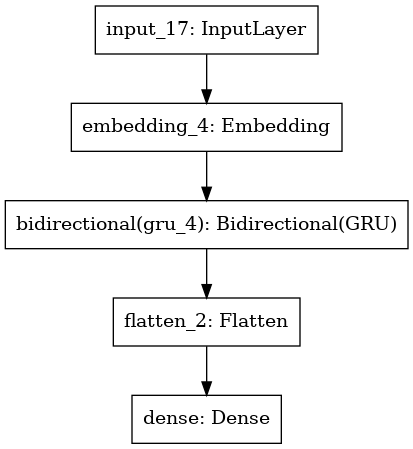

In [70]:

flatten=tf.keras.layers.Flatten()(gru)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(flatten)
model=tf.keras.Model(inputs,outputs)
tf.keras.utils.plot_model(model)

# Modeling/Training

In [ ]:
#compiling the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',
                     tf.keras.metrics.AUC(name='auc')])

In [77]:
#fitting the model
history=model.fit(
    train_inputs,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(
              monitor='val_accuracy',
              patience=2,
              restore_best_weights=True)])

Epoch 1/20
  2/359 [..............................] - ETA: 20:18 - loss: 0.6623 - accuracy: 0.6094 - auc: 0.6441

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_inputs,test_labels)